In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from config_images import *
import matplotlib.gridspec as gridspec

In [2]:
#save_path = "/home/labic/Projects/Alerce/datasets/simulated_data/image_sequences"
save_path = "../../datasets/simulated_data/image_sequences/good_zero_points_good_zero_points10"
f = h5py.File(save_path+".hdf5", "r")
fields = list(f.keys())
#stats = np.load("/home/toshiba/rodrigo/simulated_lightcurves/multiclass_SNLS_short20000.pkl")

In [3]:
list(f.keys()) # ['Field01', 'Field02', 'Field03', 'Field04' ...]
list(f["Field01"].keys())
"""['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']"""
data_keys = ['count_lightcurves',
 'galaxy_flag',
 'galaxy_image',
 'ids',
 'images',
 'labels',
 'lc_type',
 'lightcurves',
 'obs_cond',
 'psf_image']
list(f["Field01"]["images"].keys())

['g', 'r']

In [4]:
list(f["Field01"]['obs_cond'].keys())

['airmass',
 'epoch',
 'exp_time',
 'filter',
 'flux_conversion',
 'good_quality_points',
 'limmag3',
 'limmag5',
 'obs_day',
 'seeing',
 'sky_brightness',
 'zero_point']

In [5]:
#f["Field01"]['lightcurves']['g'][0]

In [6]:
f["Field01"]['estimated_counts']['g']

<HDF5 dataset "g": shape (60, 11), type "<f8">

In [7]:
def print_shape(f, data_keys, n_fields = 5, bands = ["g", "r"]):
    fields = list(f.keys())
    for field in fields[:n_fields]:
        print("Field", field)
        #data_keys = list(f[field].keys())
        for k in data_keys:
            for b in bands:
                print("key:",k," band:", b)
                if k not in ["galaxy_flag", "ids", "labels", "lc_type", "obs_cond"]:
                    print(f[field][k][b].shape)
                elif k == "obs_cond":
                    k_keys = list(f[field][k].keys())
                    for k_obs in k_keys:
                        if k_obs in ["filter", "limmag3"]:
                            continue
                        print("obs_cond", k_obs)
                        print(f[field][k][k_obs][b].shape)
                else:
                    continue
                    #print(f[field][k].shape)
#print_shape(f, data_keys)

In [8]:
estimated_counts_key = 'estimated_counts'
estimated_error_counts_key = 'estimated_error_counts'
g_key = 'g'
r_key = 'r'
lightcurves_key = 'lightcurves'#'count_lightcurves'#

def get_magnitude_error(estimated_counts, estimated_count_error):
  f = estimated_counts
  sigma_f = np.sqrt(estimated_count_error)
  sigma_m = 1.09 * (sigma_f / f)
  return sigma_m


def get_magnitude(ADU, zp, T):
  print(zp[:])
  magnitude = zp - 2.5 * np.log10(ADU)# / T)
  #if np.isnan(magnitude).any():
  #  print("ADU %s\nT %s\nADU/T %s\nlog %s"
  #        % (str(ADU), str(T), str(ADU / T), str(np.log10(ADU / T))))
  return magnitude

def _silent_plot_lc(ax, field_data, lc_idx, plt_marker='o-'):
  field_lc = field_data[lightcurves_key]
  estimated_counts = field_data[estimated_counts_key]
  estimated_error_counts = field_data[estimated_error_counts_key]
  days = field_data["obs_cond"]["obs_day"]
  bands = list(field_data[lightcurves_key].keys())
  colors = ['y', 'r']
  for i, band in enumerate(bands):
    zp = field_data["obs_cond"]['zero_point'][band][:]
    magnitude_noisy = get_magnitude(estimated_counts[band][lc_idx], zp, 30)#estimated_counts[band][lc_idx]#
    magnitude_error = get_magnitude_error(estimated_counts[band][lc_idx],
                                          estimated_error_counts[band][lc_idx])
    # print(estimated_counts[band][lc_idx].shape)
    # print(magnitude_error)
    # print(days[band])
    # print(magnitude_noisy)
    #c
    ax.plot(days[band], field_lc[band][lc_idx], '%s%s'%(colors[i],plt_marker), label='%s; model' % band)#,
        #color=color)
    color = ax.get_lines()[i * 2].get_color()
    ax.errorbar(days[band][:], magnitude_noisy, yerr=magnitude_error, fmt='o--',
                label='%s; lightcurve' % band, color=color)
    ax.set_ylim([21, 15])
    #plt.gca().invert_yaxis()

  ax.legend()
  galaxy_flag = field_data["galaxy_flag"][lc_idx]
  lc_type = field_data["lc_type"][lc_idx]
  ax.set_title("%s; galaxy_flag: %i" % (lc_type, galaxy_flag), fontsize=15)
  return ax


def _get_field(data, field):
  if field is None:
    fields = list(data.keys())
    field = fields[int(np.random.choice(np.arange(len(fields)), 1, replace=False))]
    return field
  else:
    return field

def plot_underliying_and_lc_model(data, field=None, n_to_plot=1):
    field = _get_field(data, field)
    field_data = data[field]
    lc_idxs_to_plot = np.random.choice(np.arange(field_data[lightcurves_key][g_key].shape[0]), n_to_plot, replace=False) #[13]
    print('%s%s' % (field, str(lc_idxs_to_plot)))
    plt.close()
    for lc_idx in lc_idxs_to_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
        _silent_plot_lc(ax, field_data, lc_idx)
        
        #plt.close()
    plt.show()
    return lc_idxs_to_plot[0]


Field01
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 12)
g: (60, 11) r: (60, 12)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field02
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 16) r: (60, 21, 21, 4)
g: (60, 16) r: (60, 4)
obs days <HDF5 dataset "g": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 16), type "<f8">
obs days <HDF5 dataset "r": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 4), type "<f8">
Field02[35]
[28. 28. 28. 28. 28. 28.

/home/labic/miniconda3/envs/pavan/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


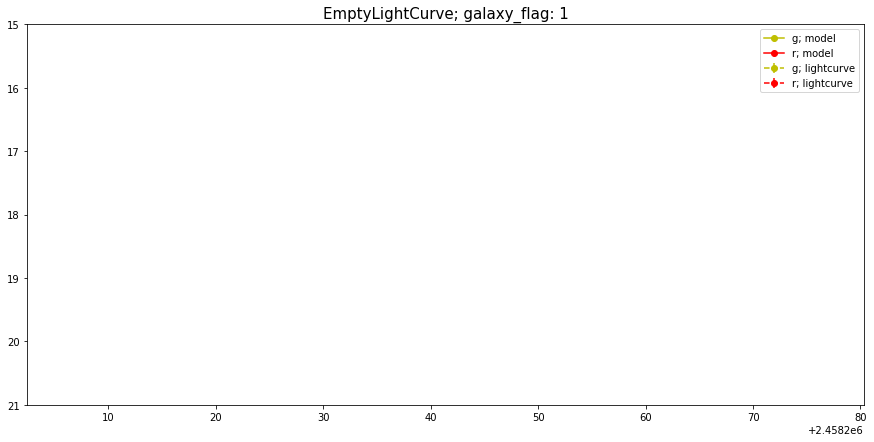

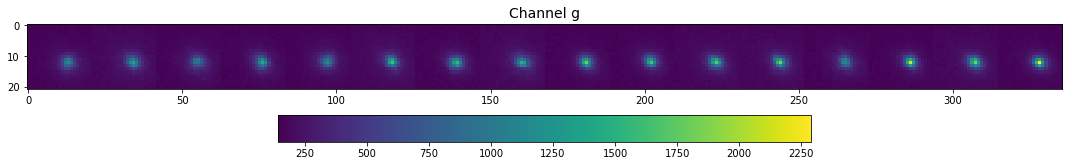

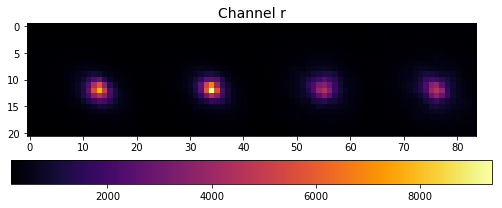


Field03
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 17) r: (60, 21, 21, 19)
g: (60, 17) r: (60, 19)
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 17), type "<f8">

Field04
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 5) r: (60, 21, 21, 25)
g: (60, 5) r: (60, 25)
obs days <HDF5 dataset "g": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 5), type "<f8">
obs days <HDF5 dataset "r": shape (25,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 5), type "<f8">

Field05
['count_lightcurves', 'estim

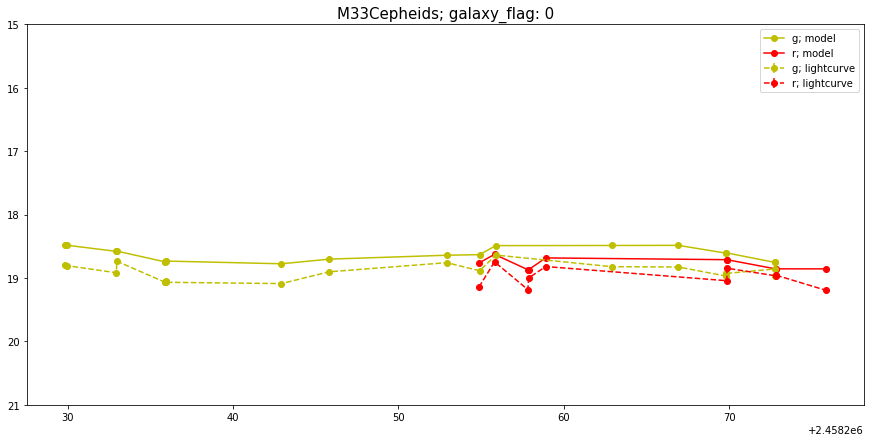

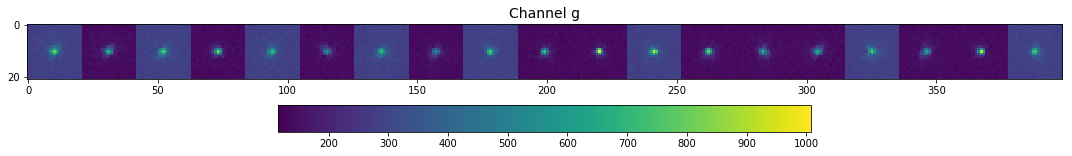

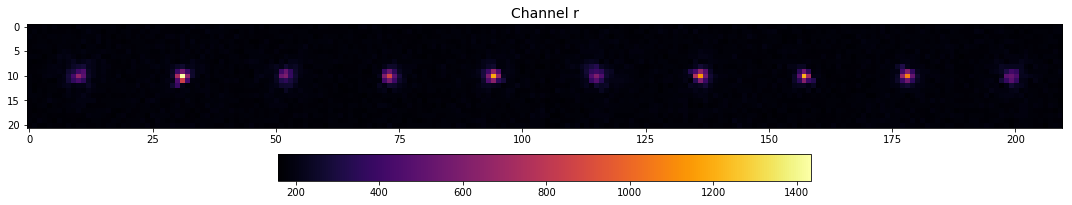


Field06
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 105) r: (60, 21, 21, 14)
g: (60, 105) r: (60, 14)
obs days <HDF5 dataset "g": shape (105,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 105), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field06[32]
[27.51023102 27.36258292 27.4056766  27.34865975 28.         27.50280023
 27.42695546 27.69236255 27.58976102 27.58706784 27.59573054 27.58345866
 27.58722019 27.5732193  27.58561349 27.59370708 27.58788967 27.58508492
 27.73902869 27.74453139 27.73855639 27.66926813 27.57837701 27.76264811
 27.79647636 27.79648399 27.85518193 27.77025056 27.76234031 27.84599876
 27.80737853 27.78613496 27.72060132 27.75148058 27.84363413 27.72629213
 27.78057146 27.66061163 27.79000378 27.75621438 27.73432016 2

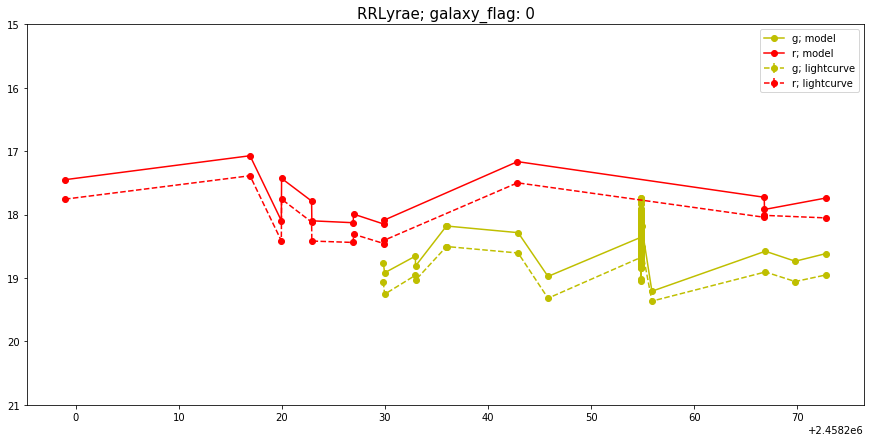

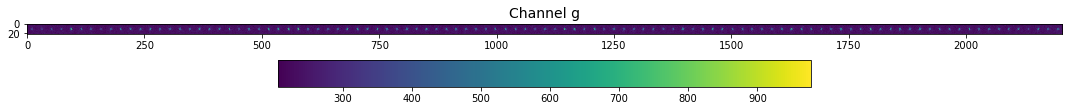

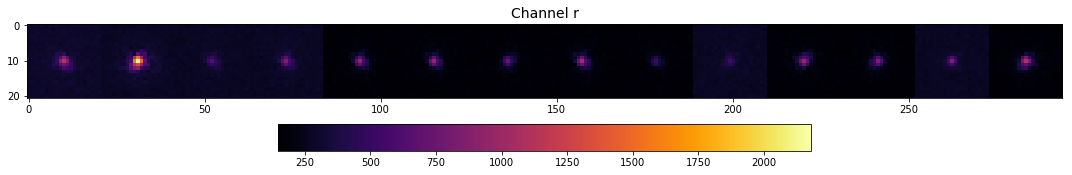


Field07
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 91) r: (60, 21, 21, 8)
g: (60, 91) r: (60, 8)
obs days <HDF5 dataset "g": shape (91,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 91), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field07[13]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28.]
[28. 28. 28. 28. 28. 28. 28. 28.]


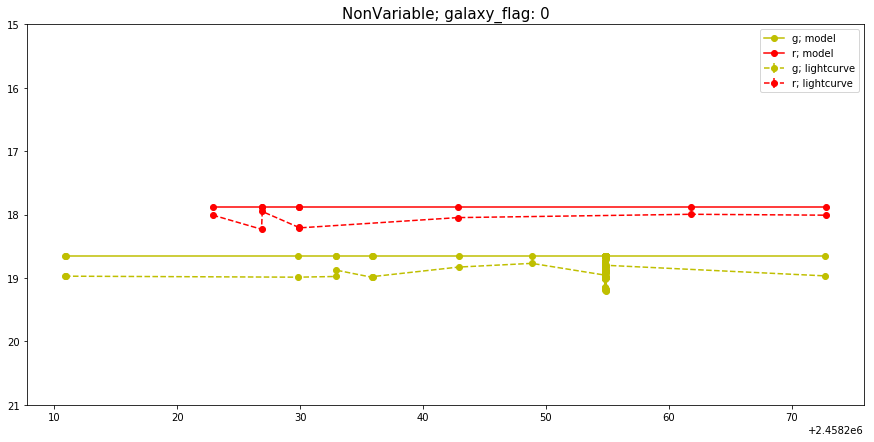

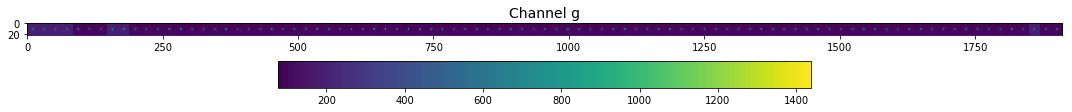

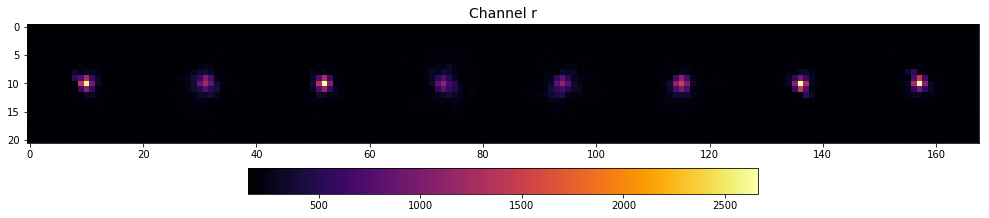


Field08
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 20)
g: (60, 11) r: (60, 20)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field09
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 13) r: (60, 21, 21, 11)
g: (60, 13) r: (60, 11)
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">
Field09[50]
[28. 28. 28. 28. 28.

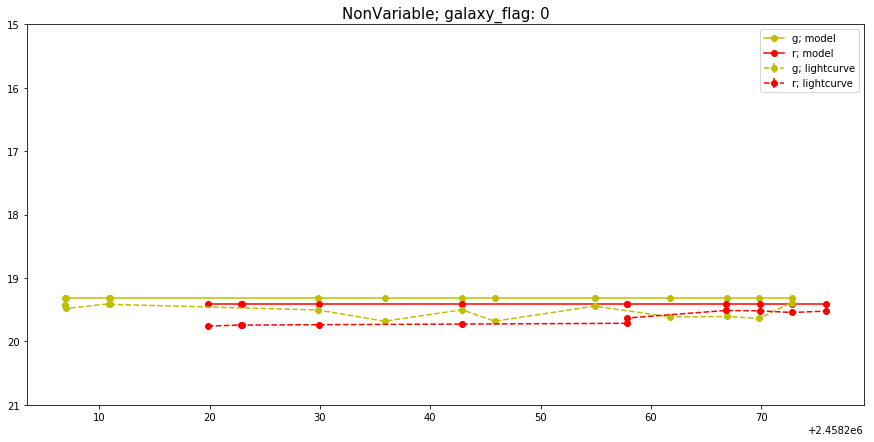

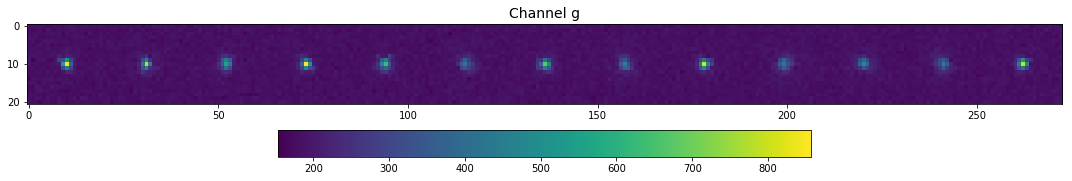

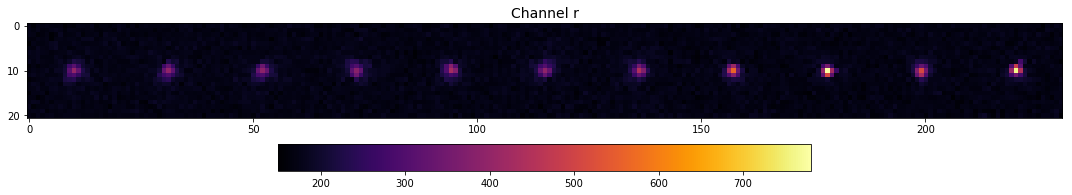


Field10
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 20) r: (60, 21, 21, 14)
g: (60, 20) r: (60, 14)
obs days <HDF5 dataset "g": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 20), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field10[18]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]


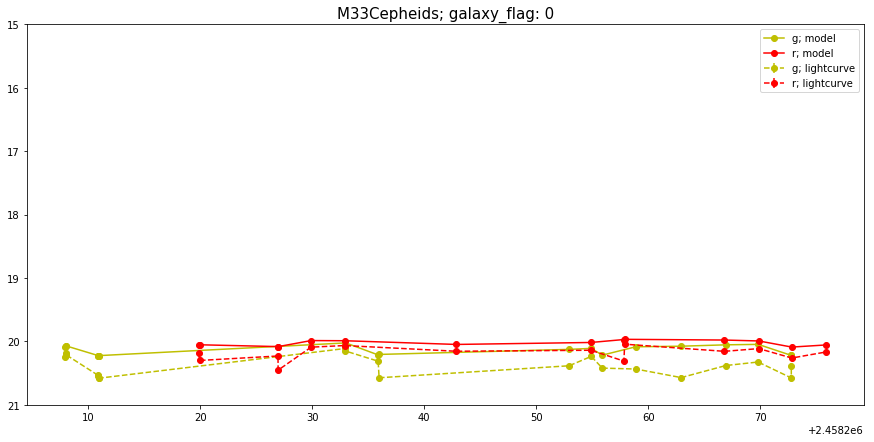

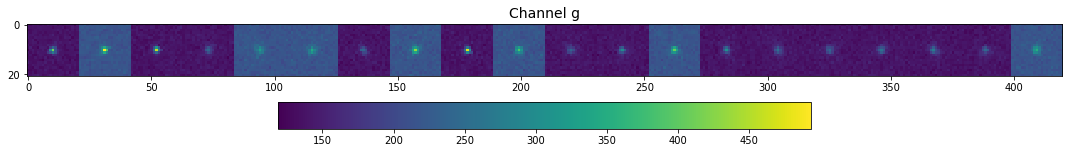

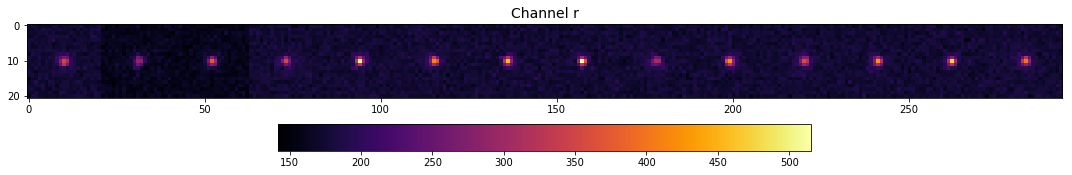


Field11
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 13) r: (60, 21, 21, 7)
g: (60, 13) r: (60, 7)
obs days <HDF5 dataset "g": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 13), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field11[37]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28.]


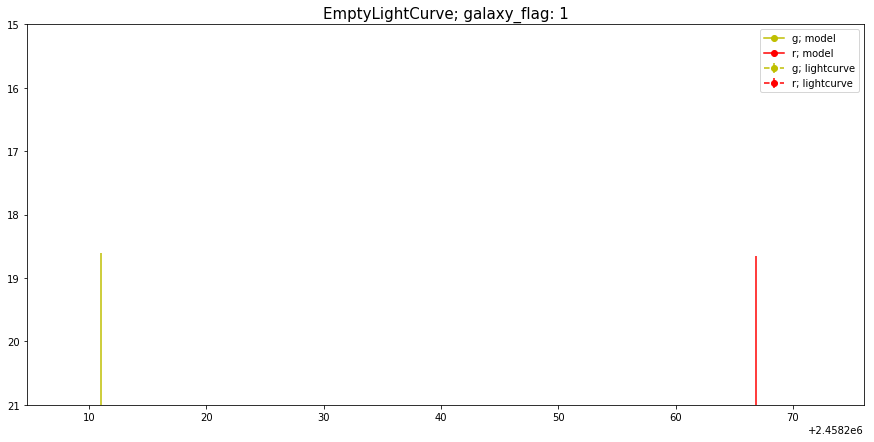

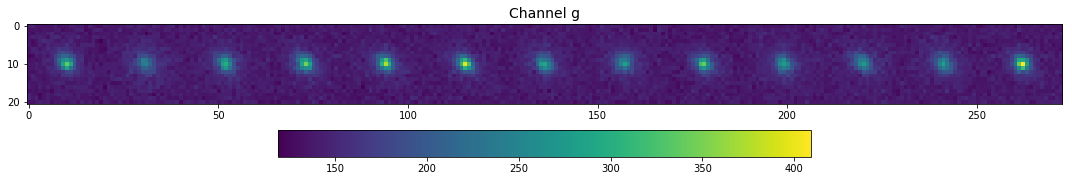

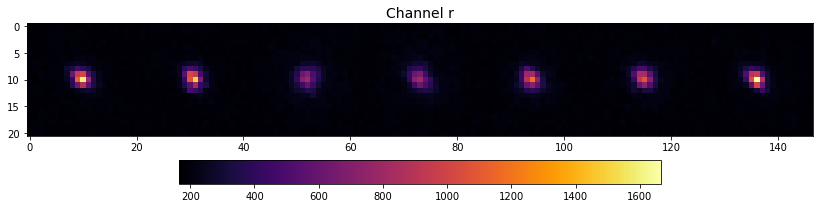


Field12
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 19) r: (60, 21, 21, 22)
g: (60, 19) r: (60, 22)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">

Field13
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 7) r: (60, 21, 21, 16)
g: (60, 7) r: (60, 16)
obs days <HDF5 dataset "g": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 7), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">

Field14
['count_lightcurves', 'estim

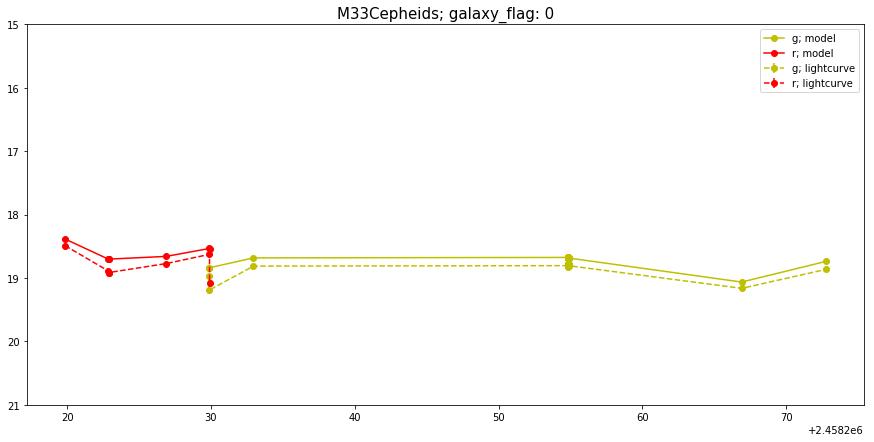

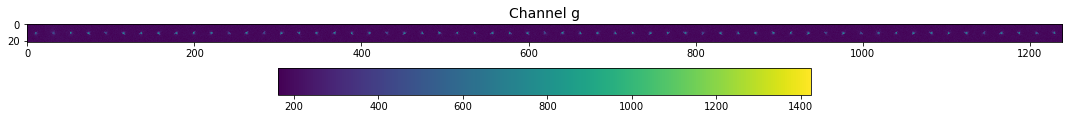

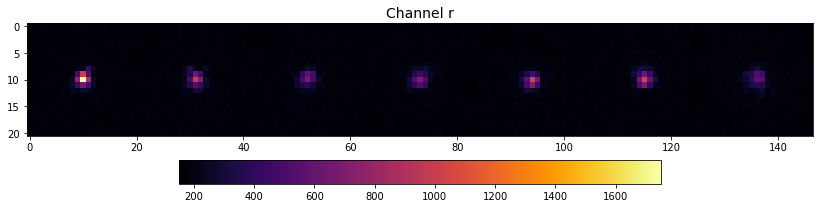


Field18
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 19) r: (60, 21, 21, 1)
g: (60, 19) r: (60, 1)
obs days <HDF5 dataset "g": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 19), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field18[10]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28.]
[28.]


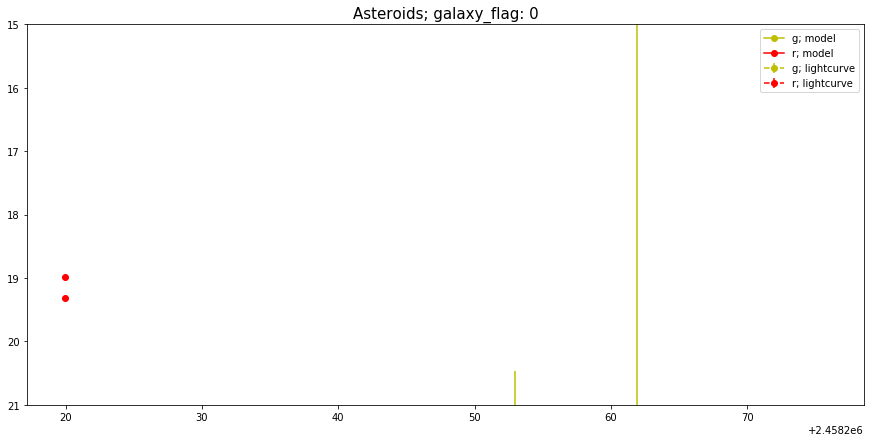

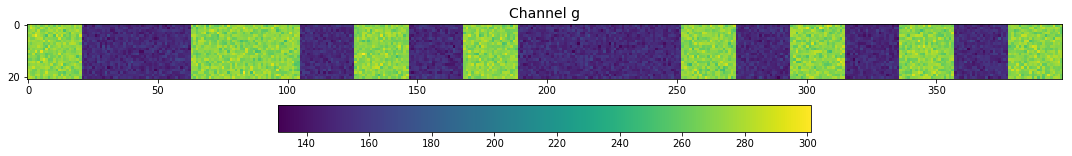

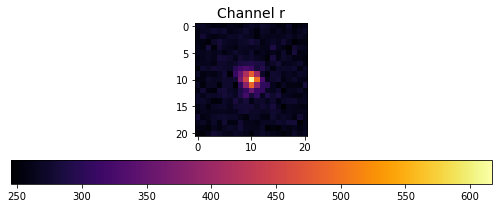


Field19
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 15) r: (60, 21, 21, 9)
g: (60, 15) r: (60, 9)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (9,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 9), type "<f8">
Field19[22]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28. 28.]


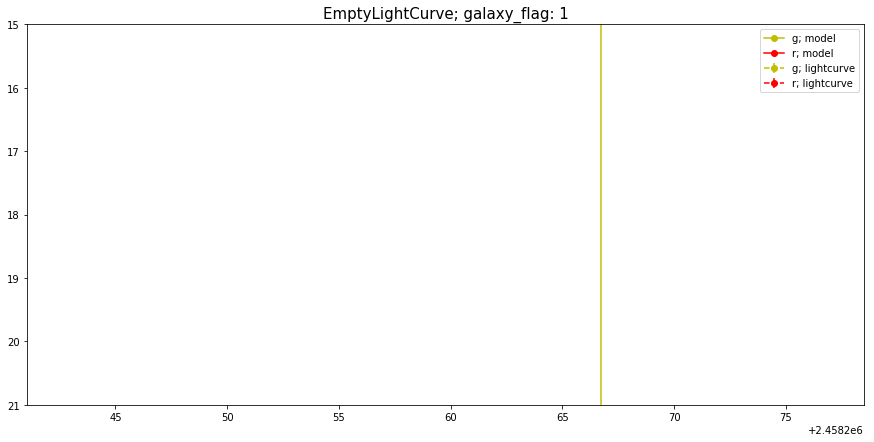

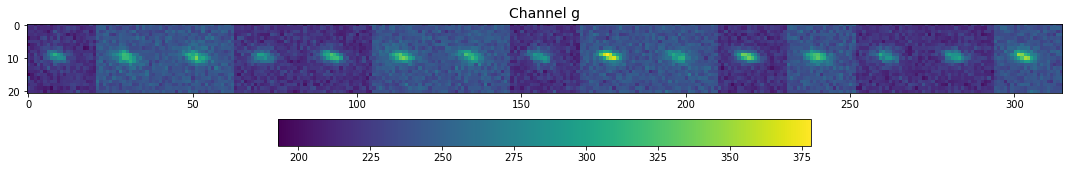

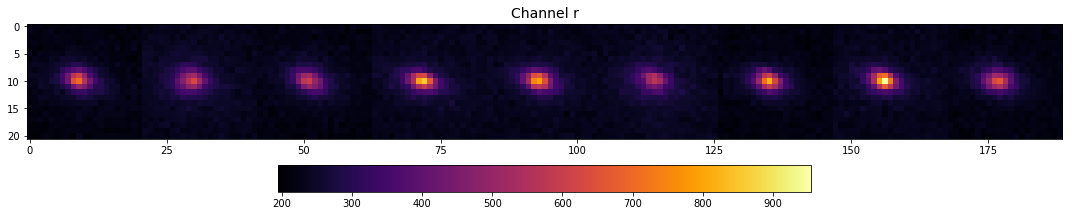


Field20
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 16)
g: (60, 14) r: (60, 16)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">

Field21
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 21) r: (60, 21, 21, 15)
g: (60, 21) r: (60, 15)
obs days <HDF5 dataset "g": shape (21,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 21), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Field21[29]
[28. 28. 28. 28. 28.

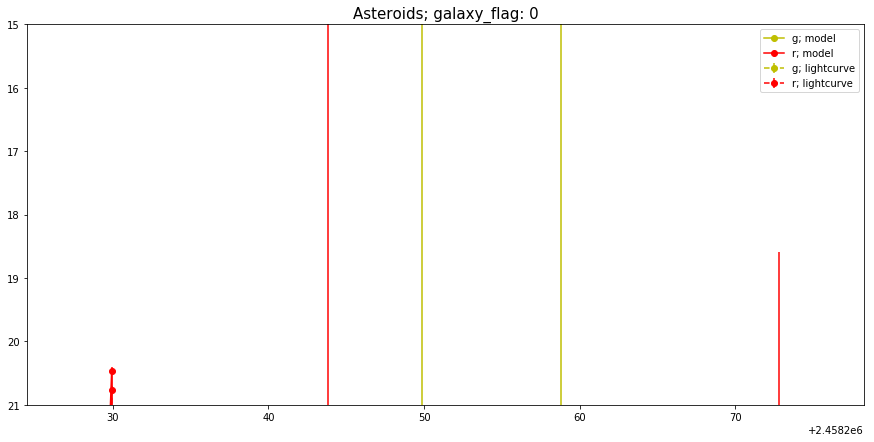

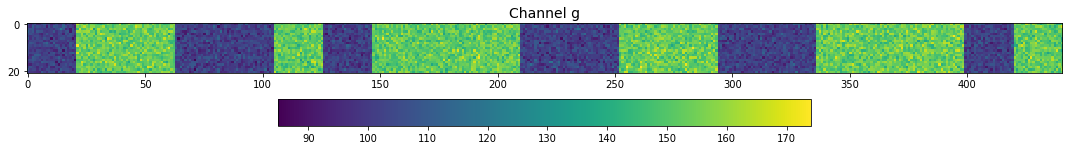

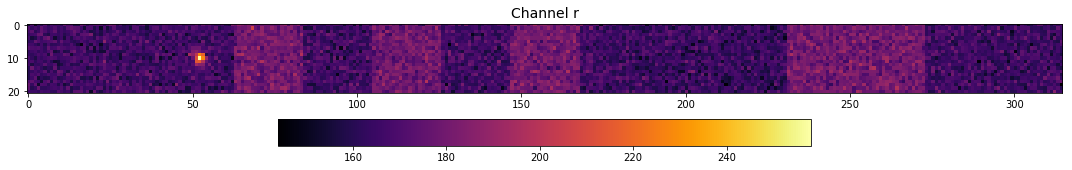


Field22
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 13)
g: (60, 11) r: (60, 13)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field23
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 28) r: (60, 21, 21, 14)
g: (60, 28) r: (60, 14)
obs days <HDF5 dataset "g": shape (28,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 28), type "<f8">
obs days <HDF5 dataset "r": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 14), type "<f8">
Field23[10]
[28. 28. 28. 28. 28.

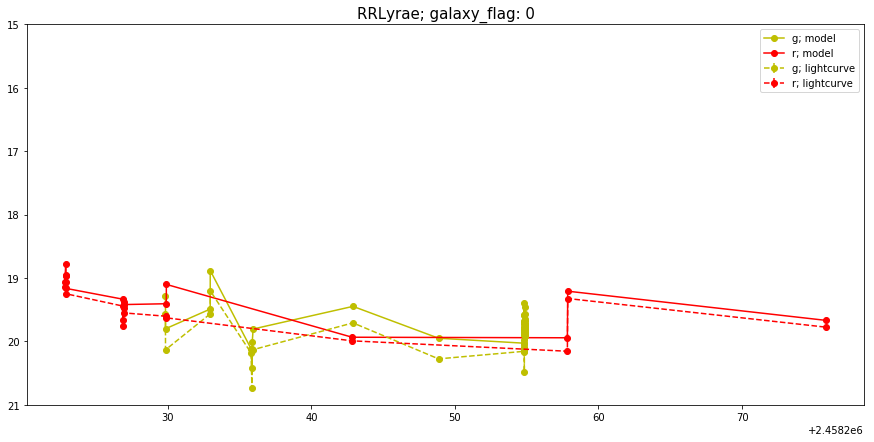

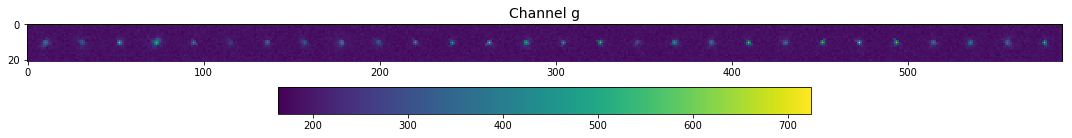

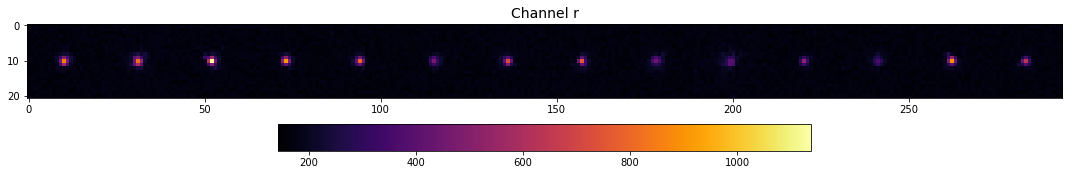


Field24
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 98) r: (60, 21, 21, 2)
g: (60, 98) r: (60, 2)
obs days <HDF5 dataset "g": shape (98,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 98), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field24[7]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28.]


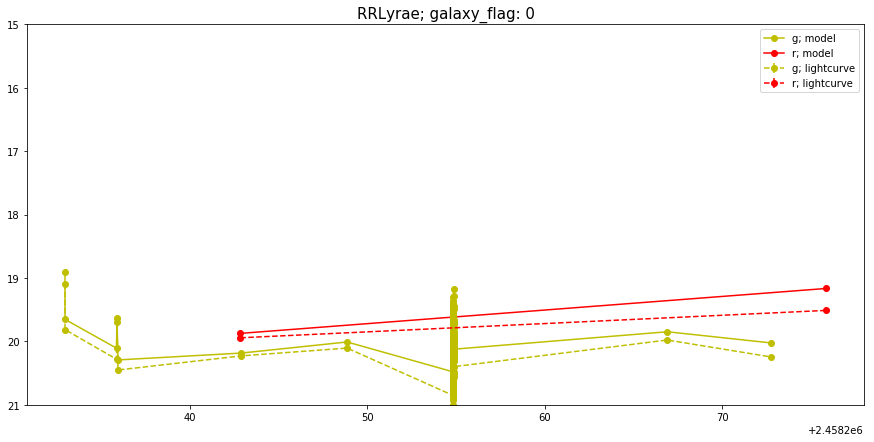

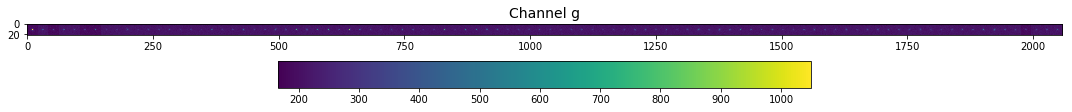

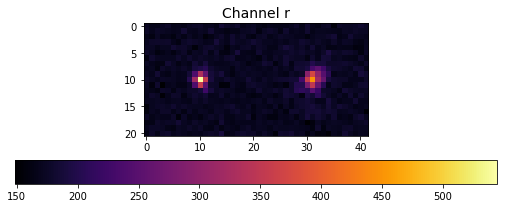


Field25
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 4) r: (60, 21, 21, 20)
g: (60, 4) r: (60, 20)
obs days <HDF5 dataset "g": shape (4,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 4), type "<f8">
obs days <HDF5 dataset "r": shape (20,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 4), type "<f8">

Field26
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 22) r: (60, 21, 21, 19)
g: (60, 22) r: (60, 19)
obs days <HDF5 dataset "g": shape (22,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 22), type "<f8">
obs days <HDF5 dataset "r": shape (19,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 19), type "<f8">
Field26[11]
[28. 28. 28. 28. 28. 28. 

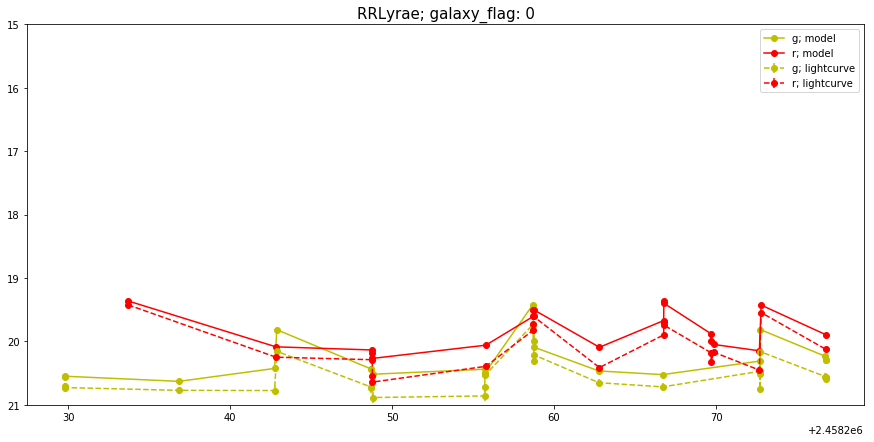

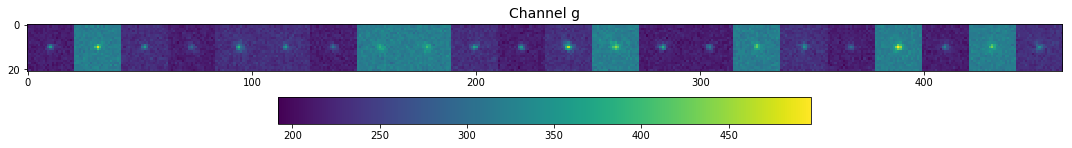

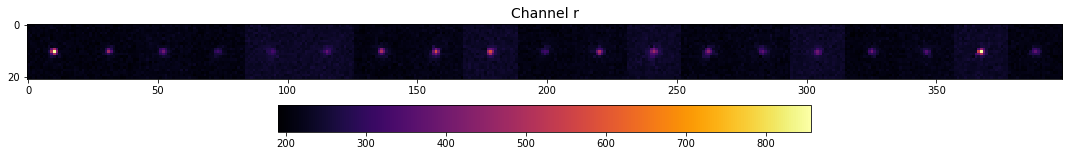


Field27
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 94) r: (60, 21, 21, 5)
g: (60, 94) r: (60, 5)
obs days <HDF5 dataset "g": shape (94,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 94), type "<f8">
obs days <HDF5 dataset "r": shape (5,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 5), type "<f8">
Field27[51]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28.]
[28. 28. 28. 28. 28.]


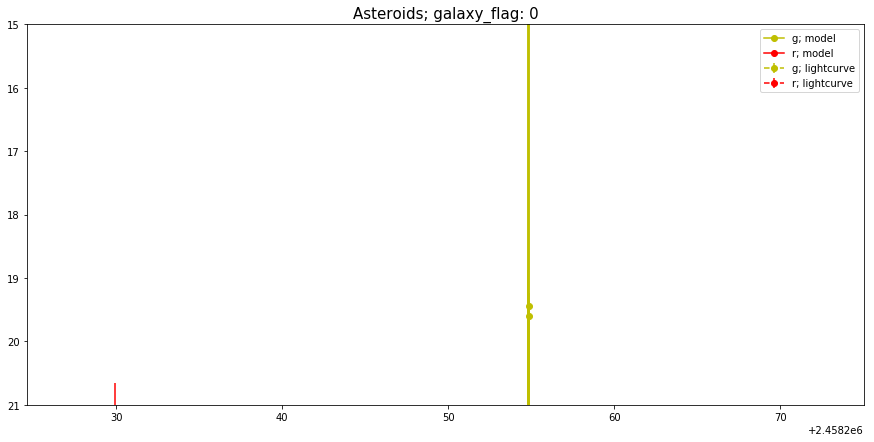

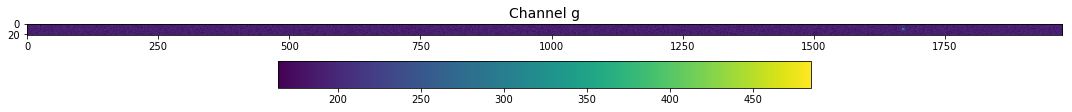

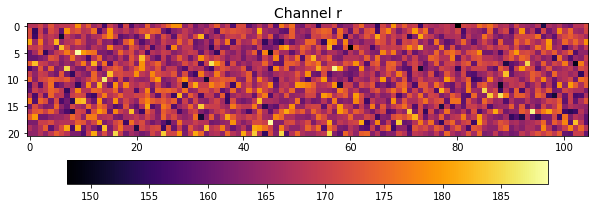


Field28
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 10) r: (60, 21, 21, 10)
g: (60, 10) r: (60, 10)
obs days <HDF5 dataset "g": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 10), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field28[59]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]


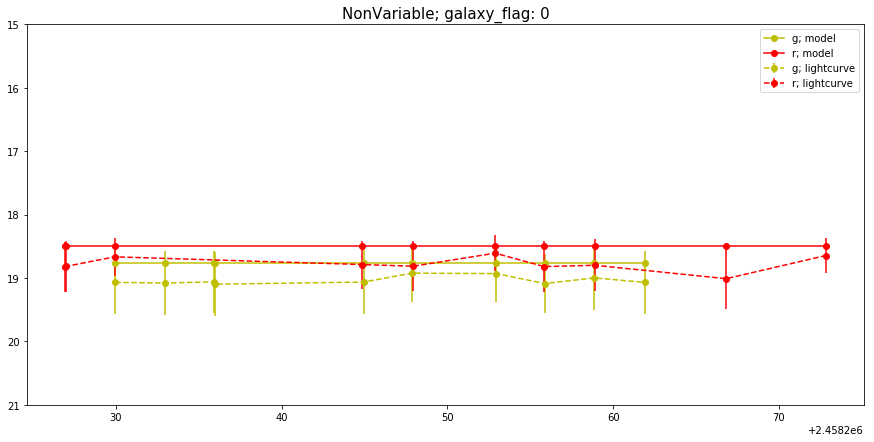

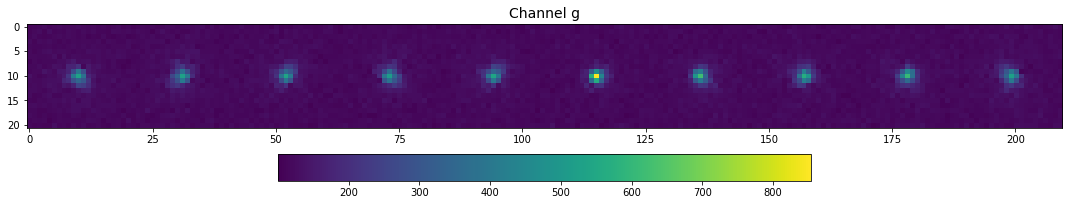

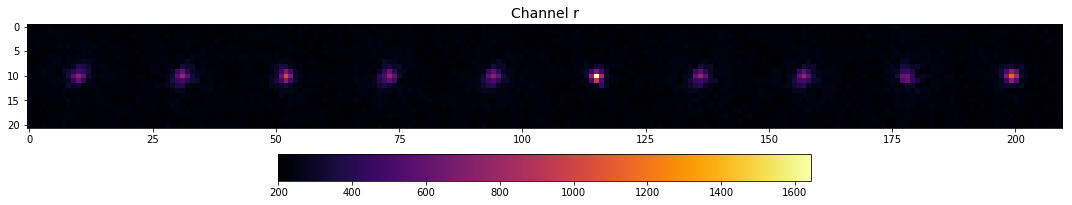


Field29
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 87) r: (60, 21, 21, 2)
g: (60, 87) r: (60, 2)
obs days <HDF5 dataset "g": shape (87,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 87), type "<f8">
obs days <HDF5 dataset "r": shape (2,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 2), type "<f8">
Field29[1]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28.]


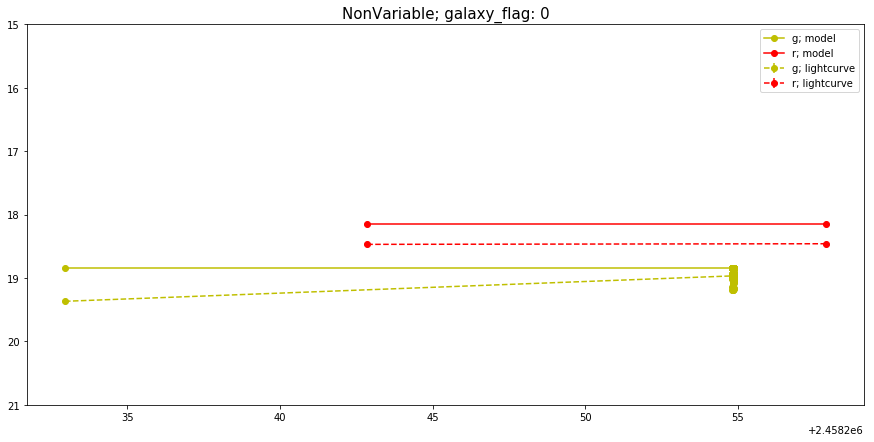

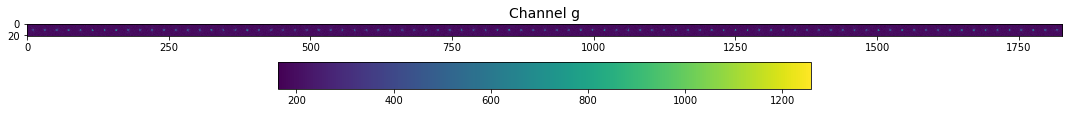

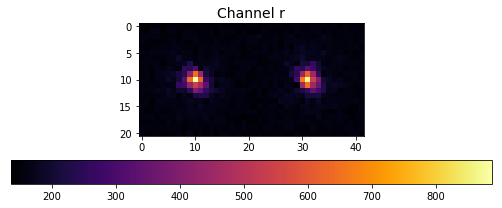


Field30
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 8) r: (60, 21, 21, 13)
g: (60, 8) r: (60, 13)
obs days <HDF5 dataset "g": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 8), type "<f8">
obs days <HDF5 dataset "r": shape (13,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">

Field32
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 17) r: (60, 21, 21, 15)
g: (60, 17) r: (60, 15)
obs days <HDF5 dataset "g": shape (17,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 17), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 15), type "<f8">
Field32[23]
[28. 28. 28. 28. 28. 28. 

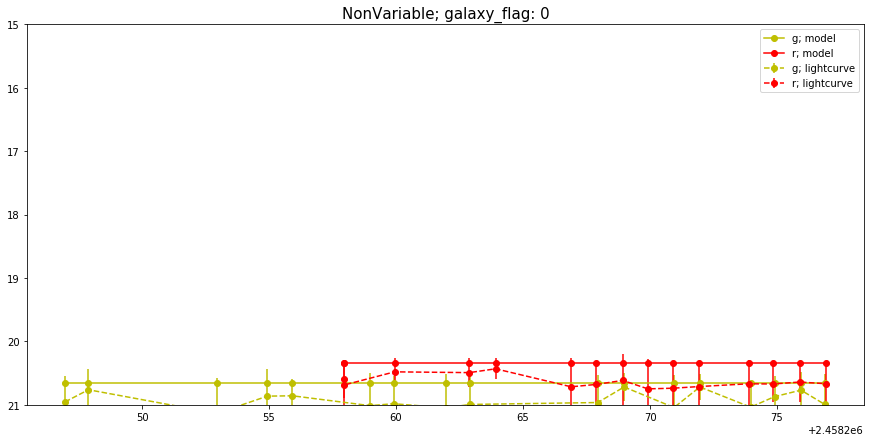

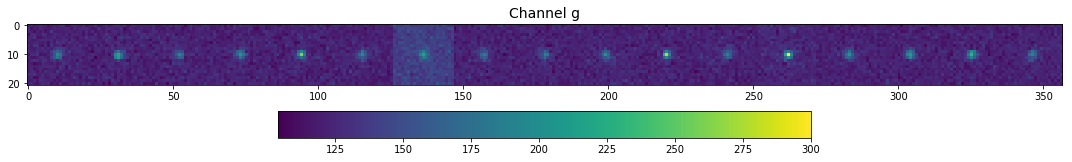

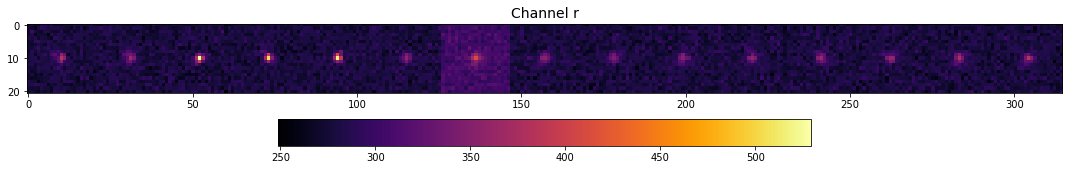


Field33
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 7)
g: (60, 14) r: (60, 7)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (7,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 7), type "<f8">
Field33[27]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28.]


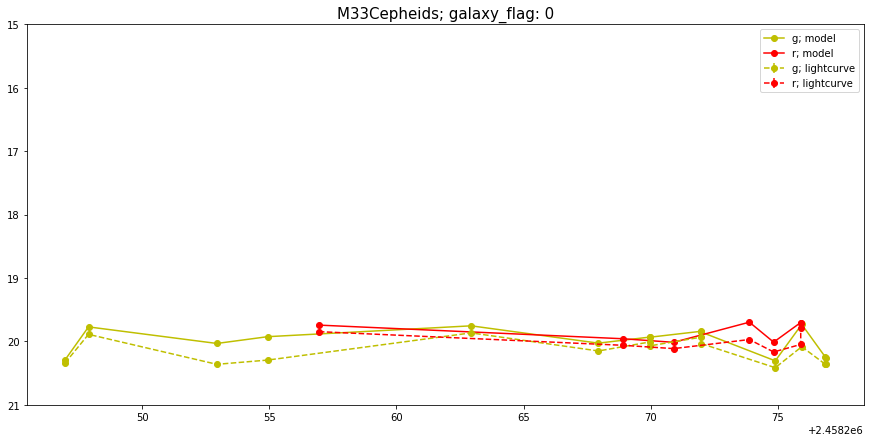

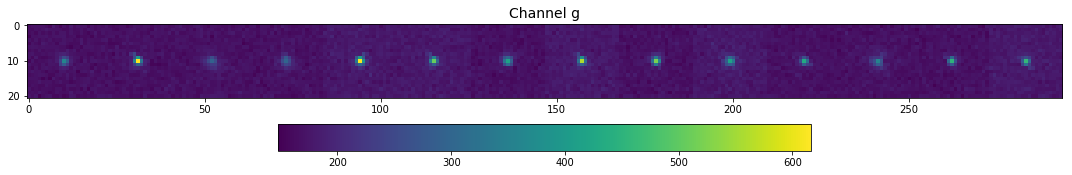

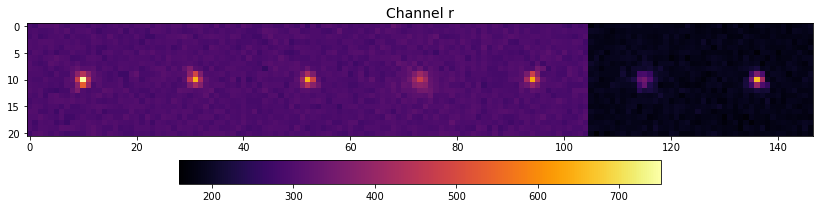


Field34
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 15) r: (60, 21, 21, 10)
g: (60, 15) r: (60, 10)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (10,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 10), type "<f8">
Field34[46]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]


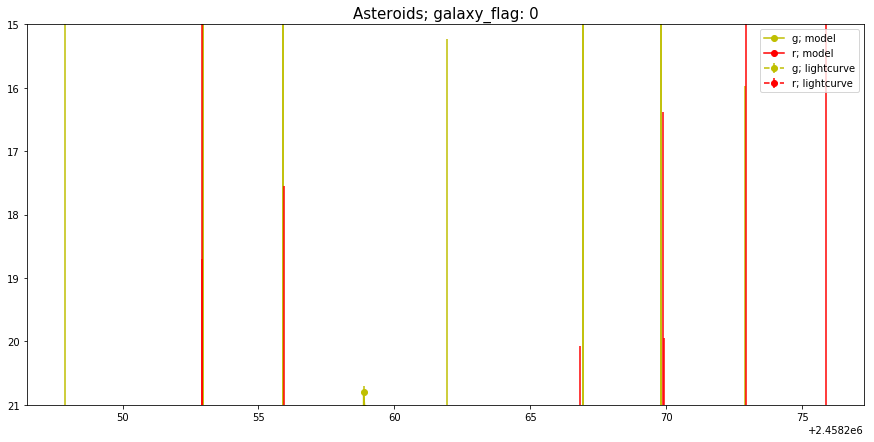

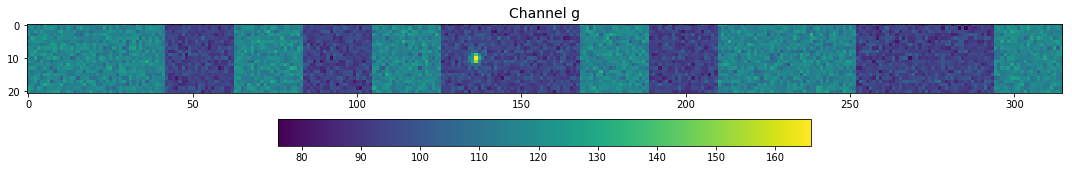

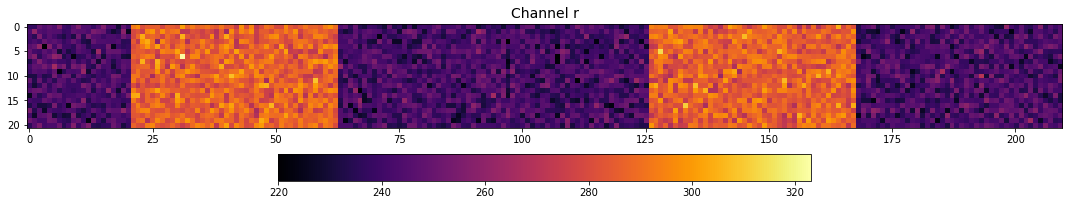


Field35
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 24) r: (60, 21, 21, 1)
g: (60, 24) r: (60, 1)
obs days <HDF5 dataset "g": shape (24,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 24), type "<f8">
obs days <HDF5 dataset "r": shape (1,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 1), type "<f8">
Field35[0]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28.]
[28.]


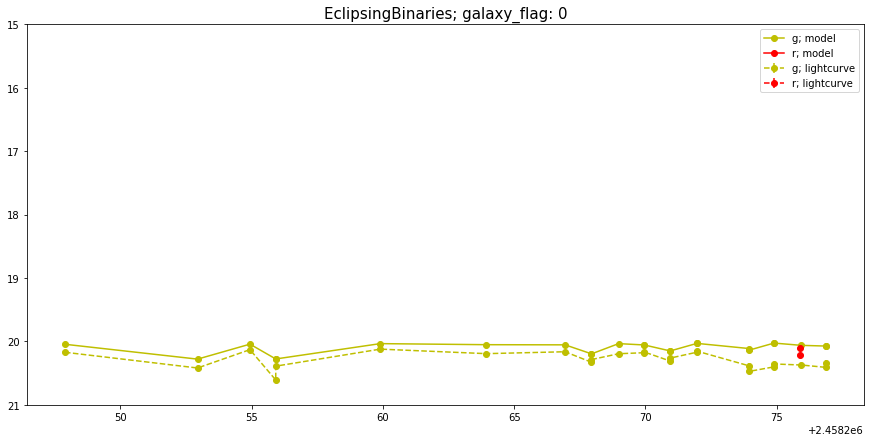

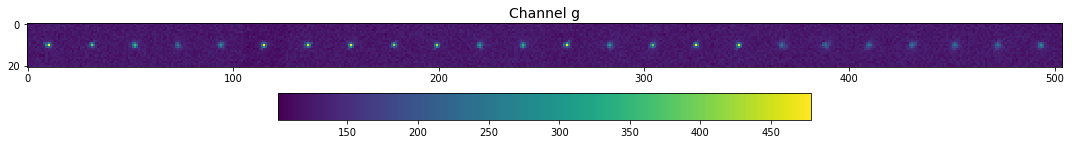

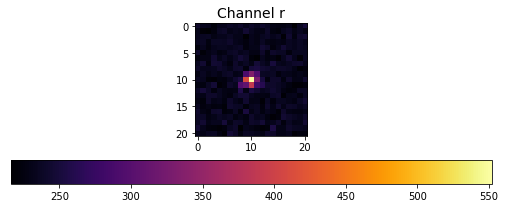


Field36
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 12)
g: (60, 14) r: (60, 12)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (12,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 12), type "<f8">
Field36[32]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]


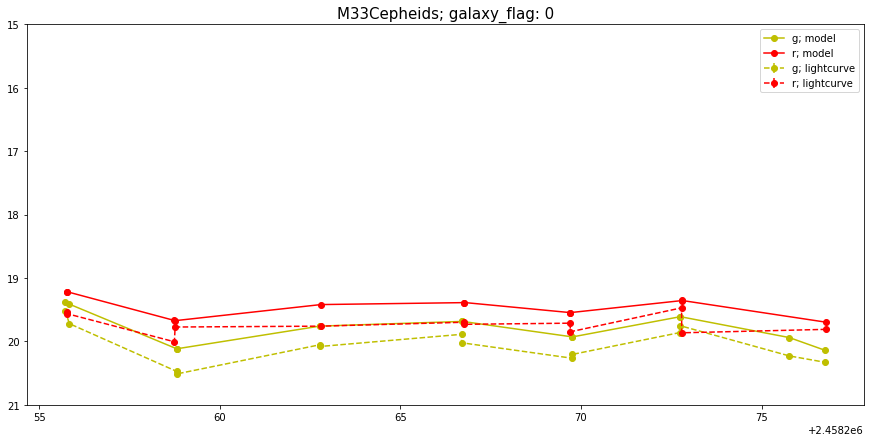

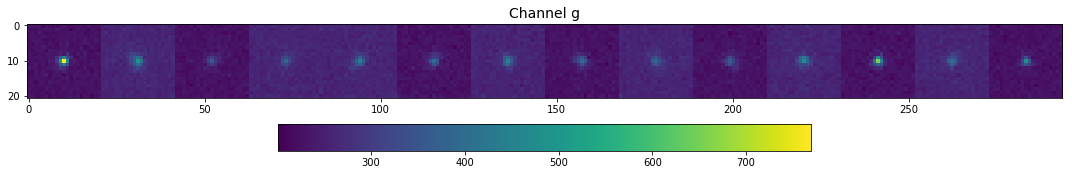

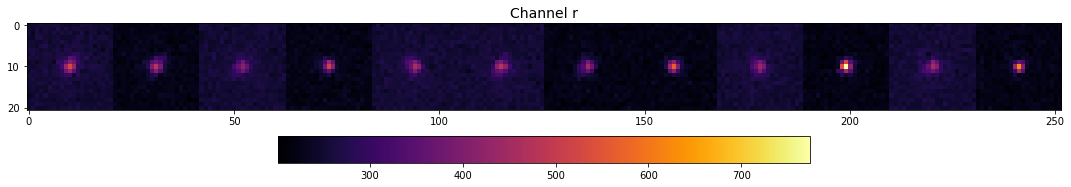


Field38
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 14) r: (60, 21, 21, 11)
g: (60, 14) r: (60, 11)
obs days <HDF5 dataset "g": shape (14,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 14), type "<f8">
obs days <HDF5 dataset "r": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">
Field38[40]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]


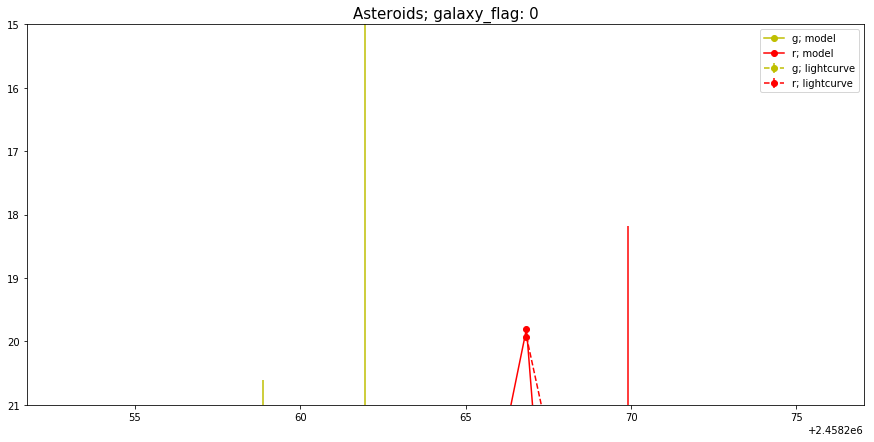

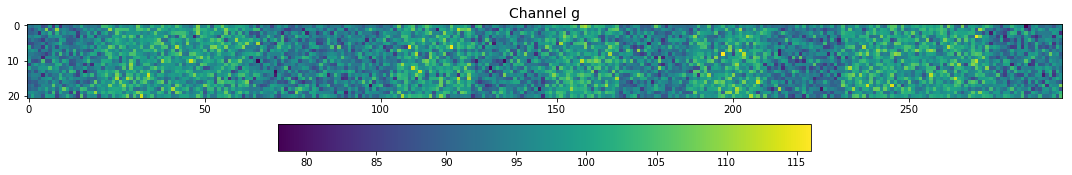

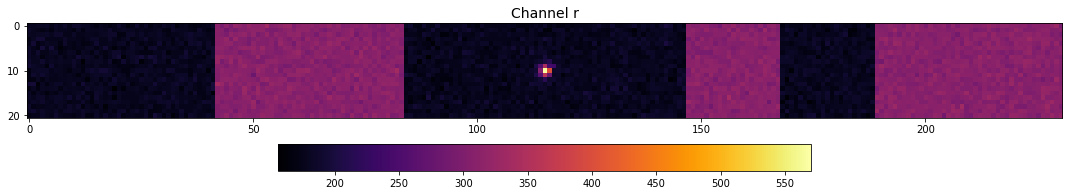


Field39
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 27) r: (60, 21, 21, 16)
g: (60, 27) r: (60, 16)
obs days <HDF5 dataset "g": shape (27,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 27), type "<f8">
obs days <HDF5 dataset "r": shape (16,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 16), type "<f8">
Field39[40]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.
 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28.         28.         28.         28.         28.         28.
 27.73977351 27.63833618 27.63943887 27.61179829 27.57157779 27.5320611
 27.49228048 27.47719669 27.44867849 27.44552994]


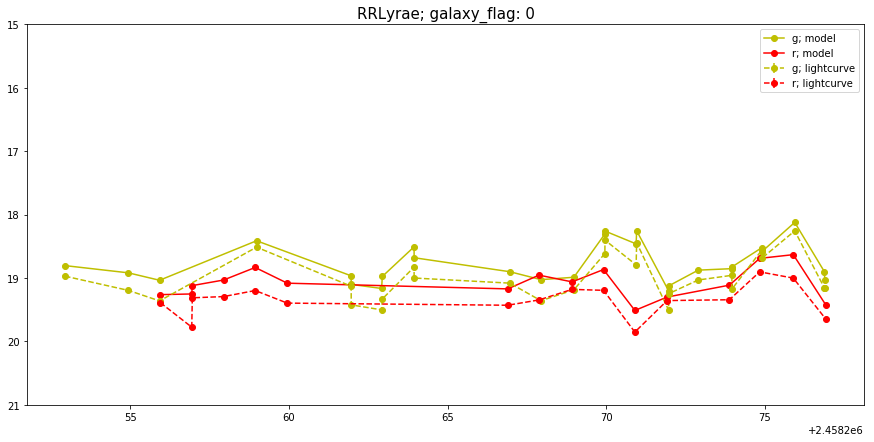

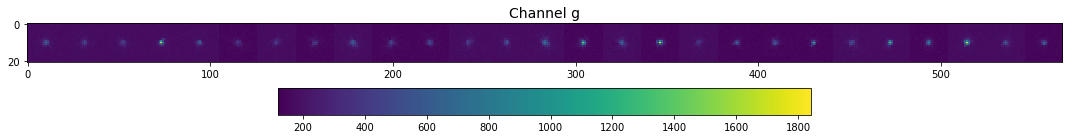

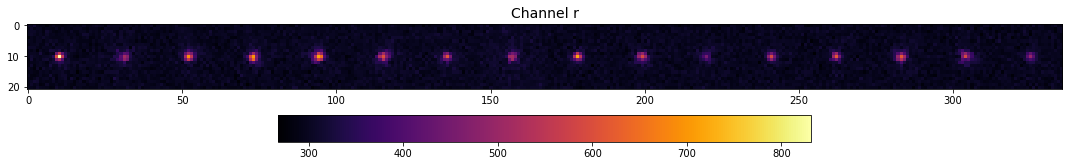


Field40
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 15) r: (60, 21, 21, 8)
g: (60, 15) r: (60, 8)
obs days <HDF5 dataset "g": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 15), type "<f8">
obs days <HDF5 dataset "r": shape (8,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 8), type "<f8">
Field40[22]
[28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28. 28.]
[28. 28. 28. 28. 28. 28. 28. 28.]


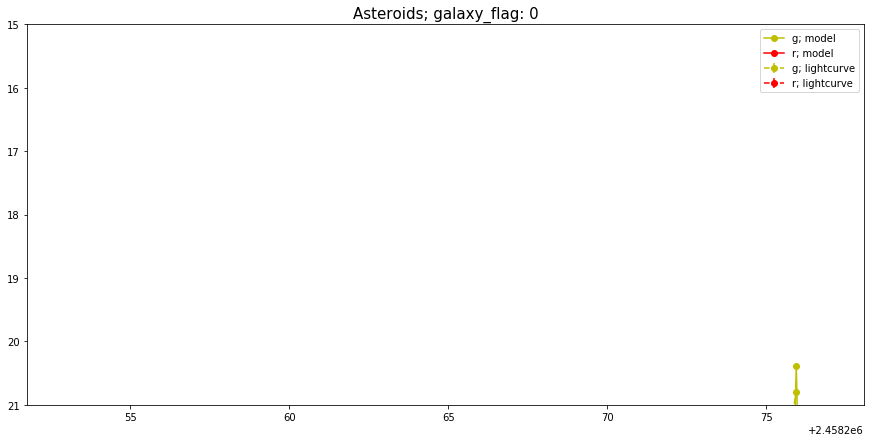

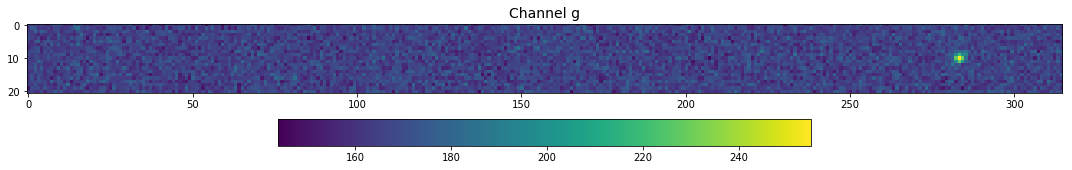

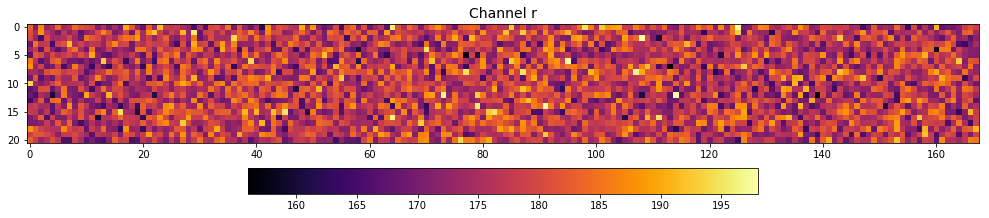


Field41
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 3) r: (60, 21, 21, 23)
g: (60, 3) r: (60, 23)
obs days <HDF5 dataset "g": shape (3,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 3), type "<f8">
obs days <HDF5 dataset "r": shape (23,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 3), type "<f8">

Field43
['count_lightcurves', 'estimated_counts', 'estimated_error_counts', 'galaxy_flag', 'galaxy_image', 'ids', 'images', 'labels', 'lc_type', 'lightcurves', 'obs_cond', 'psf_image']
g: (60, 21, 21, 11) r: (60, 21, 21, 15)
g: (60, 11) r: (60, 15)
obs days <HDF5 dataset "g": shape (11,), type "<f8">
estimated_counts <HDF5 dataset "g": shape (60, 11), type "<f8">
obs days <HDF5 dataset "r": shape (15,), type "<f8">
estimated_counts <HDF5 dataset "r": shape (60, 11), type "<f8">

Field44
['count_lightcurves', 'estim

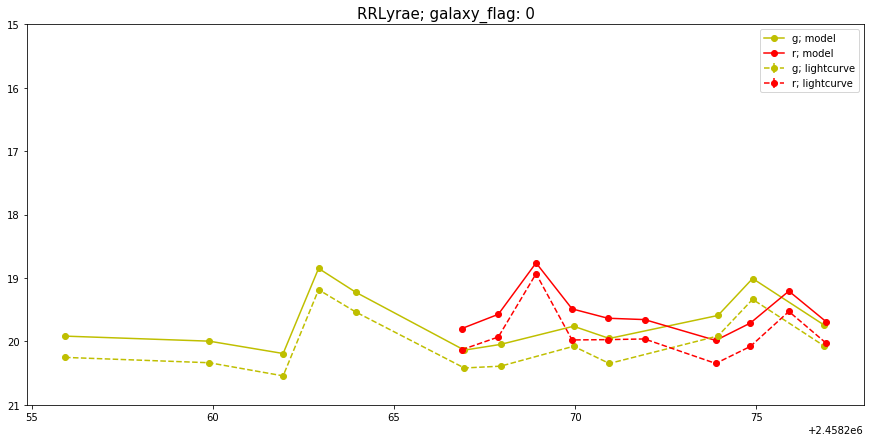

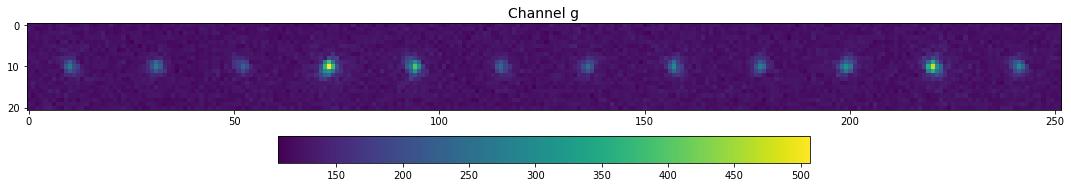

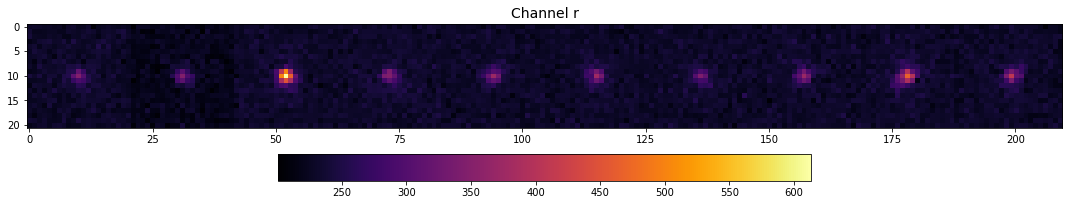

In [9]:
bands = ["g", "r"]
n_per_field = 3
for field in fields:
    print('\n%s' % (field))
    #if field in ['Field01', 'Field03', 'Field04', 'Field08', 'Field12']:
    #    continue
    field_data = f[field]
    print(list(field_data))
    field_images = field_data["images"]
    print("g:", field_images["g"].shape, "r:", field_images["r"].shape)
    field_lc = field_data["lightcurves"]
    print("g:", field_lc["g"].shape, "r:", field_lc["r"].shape)
    days = field_data["obs_cond"]["obs_day"]
    #print(field_data["obs_cond"]["sky_brightness"]["r"][:])
    
    for band in bands:
        print('obs days %s' % str(days[band]))
        print('estimated_counts %s' % str(field_data['estimated_counts'][band]))
    if  days[bands[1]].shape[0]!=field_data['estimated_counts'][bands[1]].shape[1]:
        continue
    idx = plot_underliying_and_lc_model(f, field=field)
    lc_type = field_data["lc_type"][idx]
    
    """
    plt.figure(figsize=(15, 7))
    for band in bands:
        plt.plot(days[band], field_lc[band][0, ...], "o-", label=band)
    galaxy_flag = field_data["galaxy_flag"][0]
    plt.title(lc_type+" galaxy_flag", fontsize=15)
    plt.ylim([21, 15])
    plt.legend()
    plt.show()
    """
    for band in bands:
        n_images = field_lc[band].shape[1]
        plt.figure(figsize=(15,3))#3*n_images,3))
        empty_image = np.zeros((21, 21*n_images,))
        for i in range(n_images):
            empty_image[:, i*21:(i+1)*21] = field_images[band][idx, :, :, i]
        if band == "g":
            c_map = "viridis"
        else:
            c_map = "inferno"
        plt.imshow(empty_image, cmap=c_map)
        plt.title('Channel %s' % band, fontsize=14)#np.amin(empty_image))
        plt.colorbar(orientation="horizontal")
        plt.tight_layout()
        plt.show()